## ChatGPT 4.0 API

In [2]:
import os
API_KEY = os.getenv("OPENAI_API_KEY")

In [3]:
from openai import OpenAI

client = OpenAI(
    api_key = API_KEY
)

response = client.chat.completions.create(
  model="gpt-4-turbo",
  messages=[
    {
      "role": "user",
      "content": [
        {"type": "text", "text": "What’s in this image?"},
        {
          "type": "image_url",
          "image_url": {
            "url": "https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg/2560px-Gfp-wisconsin-madison-the-nature-boardwalk.jpg",
          },
        },
      ],
    }
  ],
  max_tokens=300,
)


In [4]:
import base64
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

In [5]:
image_path = "image1.jpg"
base64_image = encode_image(image_path)

In [6]:
response = client.chat.completions.create(
  model="gpt-4-turbo",
  messages=[
    {
      "role": "user",
      "content": [
        {"type": "text", "text": "What’s in this image, answer in two sentences?"},
        {
          "type": "image_url",
          "image_url": {
            "url":  f"data:image/jpeg;base64,{base64_image}",
          },
        },
      ],
    }
  ],
  max_tokens=300,
)

In [7]:
reply = response.choices[0].message.content
print(reply)

The image shows three colorful bowls in orange, green, and blue, placed side by side on a pink paper background. Additionally, there are four cubes in orange, blue, green, and red colors displayed in front of the bowls.


## LangChain ChatGPT4_vision

In [9]:
from langchain.chains import TransformChain
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain import globals
from langchain_core.runnables import chain

In [10]:
import os
os.environ["OPENAI_API_KEY"] = API_KEY

In [17]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List

class ImageInformation(BaseModel):
    """Information about an image."""
    image_description: list = Field(description="list each available objects")
    planner: list = Field(description="list each of the movement step to place objects into bowls of corresponding colors ")

In [13]:
from langchain_core.output_parsers import JsonOutputParser

parser = JsonOutputParser(pydantic_object=ImageInformation)

In [18]:
from langchain.schema import HumanMessage, SystemMessage, AIMessage

In [20]:
# Set verbose
globals.set_debug(True)

@chain
def image_model(inputs: dict):
 """Invoke model with image and prompt."""
 model = ChatOpenAI(temperature=0.5, model="gpt-4-vision-preview", max_tokens=1024)

 msg = model.invoke(
             [  SystemMessage(content="You are a robot controller to control the robot to pick and place object. \
                  available scene objects: ['green bowl'], ['red bowl'], ['blue bowl'], ['green block'], ['blue block'], ['red block']\
                  available movement: ['move'], ['pick'], [place]"),
              
               HumanMessage(
             content=[
             {"type": "text", "text": inputs["prompt"]},
             {"type": "text", "text": parser.get_format_instructions()},
             {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{inputs['image']}"}},
             ])]
             )
 return msg.content

In [23]:
def load_image(inputs: dict) -> dict:
    """Load image from file and encode it as base64."""
    image_path = inputs["image_path"]
  
    def encode_image(image_path):
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    image_base64 = encode_image(image_path)
    return {"image": image_base64}

In [24]:
load_image_chain = TransformChain(
    input_variables=["image_path"],
    output_variables=["image"],
    transform=load_image
)

In [25]:
def get_image_informations(image_path: str) -> dict:
   vision_prompt = """
   Given the image, provide the following information:
   - A count of how many people are in the image
   - A list of the main objects present in the image
   - A description of the image
   """
   vision_chain = load_image_chain | image_model | parser
   return vision_chain.invoke({'image_path': f'{image_path}', 
                               'prompt': vision_prompt})

In [ ]:
result = get_image_informations("image1.jpg")

In [27]:
print(result['planner'])
print(result['image_description'])

['move to red block', 'pick red block', 'move to red bowl', 'place red block', 'move to green block', 'pick green block', 'move to green bowl', 'place green block', 'move to blue block', 'pick blue block', 'move to blue bowl', 'place blue block']
['red bowl', 'green bowl', 'blue bowl', 'red block', 'green block', 'blue block']


In [61]:
result = {}
result['planner'] = ['move to red block', 'pick red block', 'move to red bowl', 'place red block', 'move to green block', 'pick green block', 'move to green bowl', 'place green block', 'move to blue block', 'pick blue block', 'move to blue bowl', 'place blue block']
result['image_description'] = ['red bowl', 'green bowl', 'blue bowl', 'red block', 'green block', 'blue block']

In [65]:
movements = ['move', 'pick', 'place']

In [66]:
items = result['image_description']
instruction = result['planner'][0]
for item in items:
    if item in instruction:
        break
print(item)

for movement in movements:
    if movement in instruction:
        break
print(movement)

red block
move


## Zero shot object detection

In [2]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [53]:
import requests
from PIL import Image
import numpy as np
import torch
from transformers import AutoProcessor, Owlv2ForObjectDetection, OwlViTImageProcessor, OwlViTProcessor
from transformers.utils.constants import OPENAI_CLIP_MEAN, OPENAI_CLIP_STD

processor = OwlViTProcessor.from_pretrained("google/owlv2-base-patch16-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")

# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
image = Image.open(r'image3.jpg')
texts = [["panda"]]
inputs = processor(text=texts, images=image, return_tensors="pt")

In [54]:
# forward pass
with torch.no_grad():
    outputs = model(**inputs)

# Note: boxes need to be visualized on the padded, unnormalized image
# hence we'll set the target image sizes (height, width) based on that

def get_preprocessed_image(pixel_values):
    pixel_values = pixel_values.squeeze().numpy()
    unnormalized_image = (pixel_values * np.array(OPENAI_CLIP_STD)[:, None, None]) + np.array(OPENAI_CLIP_MEAN)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    unnormalized_image = Image.fromarray(unnormalized_image)
    return unnormalized_image

unnormalized_image = get_preprocessed_image(inputs.pixel_values)

target_sizes = torch.Tensor([unnormalized_image.size[::-1]])
# Convert outputs (bounding boxes and class logits) to final bounding boxes and scores
results = processor.post_process_object_detection(
    outputs=outputs, threshold=0.2, target_sizes=target_sizes
)

i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")

Detected panda with confidence 0.962 at location [294.14, 184.82, 657.92, 795.3]


In [57]:
from PIL import ImageDraw
image = Image.open(r'image3.jpg')
draw = ImageDraw.Draw(image)
boxes2 = boxes.tolist()
scores2 = scores.tolist()
labels2 = labels.tolist()
width, Height = image.size
for box, score, label in zip(boxes2, scores2, labels2):
    if score < 0.3:
        continue
    xmin, ymin, xmax, ymax = box
    xmin = xmin*width/960
    xmax = xmax*width/960
    ymin = ymin*Height/960
    ymax = ymax*Height/960
    draw.rectangle((xmin, ymin, xmax, ymax), outline='red', width=2)
    # draw.rectangle((ymin, xmin, ymax, xmax), outline='red', width=2)
    draw.text((xmin, ymin), f"{texts[0][label]}: {round(score,2)}", fill = "white")

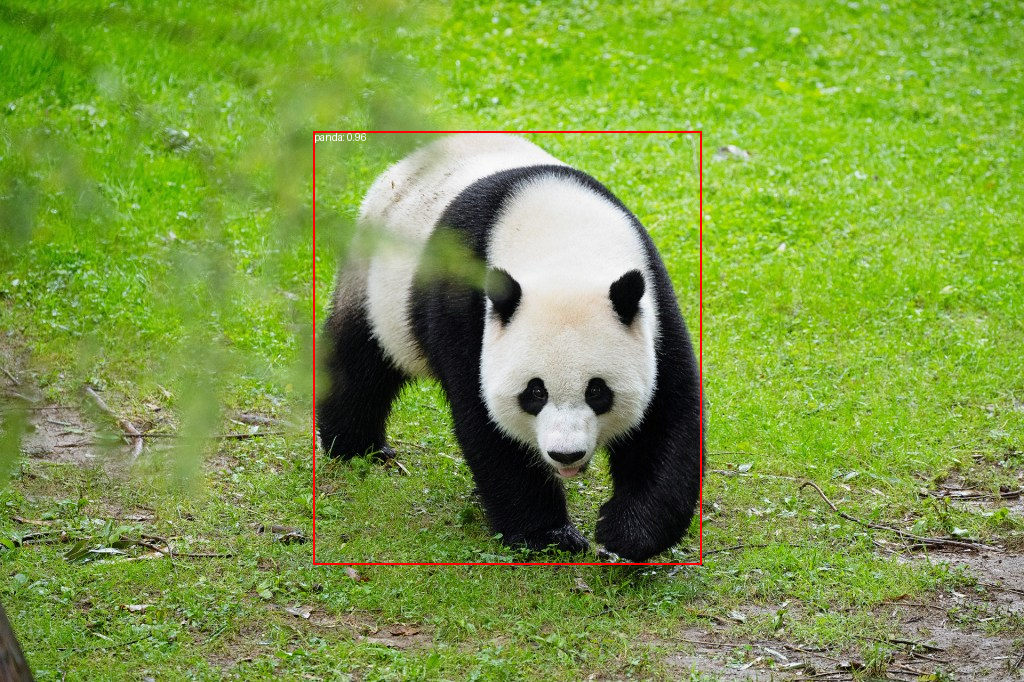

In [58]:
image